# Proyecto: Engrasandonos las manos con datos

¡Bienvenidos al segundo proyecto de la carrera de Data Science de Acamica! 

En este proyecto vamos a seguir trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es continuar con la limpieza de datos y avanzar en remover valores faltantes y remover outliers. Por otro lado, vamos a agregar nuevos atributos basados en los datos.

## Dataset: Propiedades en venta en Ciudad de Buenos Aires.

En este proyecto, trabajaremos con una muestra del conjunto de datos de propiedades en venta mencionado. En este dataset, cada fila es una propiedad en venta. A continuación vamos a describir los atributos que consideramos en esta muestra:

* id: id de la propiedad
* created_on: fecha en la que la propiedad ingresó al sitio
* operation: alquiler (rent) o venta (sell)
* property_type: tipo de propiedad (casa, departamento, ph, etcétera)
* place_with_parent_names: nombre del lugar donde se encuentra la propiedad según el publicador
* lat-lon: coordenadas concatenadas
* lat: latitud
* lon: longitud
* price: precio en la moneda especificada en currency
* currency: divisa en la que está expresada la publicación
* price_aprox_usd: precio aproximado en dólares estadounidenses
* surface_total_in_m2: superficie total (en metros cuadrados)
* surface_covered_in_m2: superficie cubierta (en metros cuadrados)
* price_usd_per_m2: precio por metro cuadrado en dólares (precio dólares / superficie)
* floor: número de piso (si corresponde)
* rooms: cantidad de ambientes
* expenses: expensas (si corresponde)
* barrio: barrio según cartografía oficial
* properati_url: url de la publicación en Properati

A continuación vamos a levantar el dataset para comenzar el procesamiento. Cabe destacar que en este caso ya fueron hechas las correcciones de coordenadas y superficies incorrectas que vimos en el proyecto anterior

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
 
sns.set_style("whitegrid")
sns.set_context("paper")

plt.rcParams['figure.figsize'] = (12,5)

In [35]:
path_dataset = 'dataset/datos_properati_limpios.csv'
df = pd.read_csv(path_dataset, parse_dates=['created_on'])

In [36]:
df.columns

Index(['created_on', 'property_type', 'place_name', 'place_with_parent_names',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms',
       'expenses', 'properati_url', 'barrio'],
      dtype='object')

In [37]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 13756 observaciones


Dado que ya lo trabajamos en el proyecto anterior, en este caso ya hemos filtrado observaciones para trabajar solo con casas (house), departamentos (apartment) y PH (PH).

### Outliers

Analicemos en primer lugar los valores extremos que puede haber en los precios y en las superficies. Esto nos va a ser útil para luego imputar usando medidas de tendencia central, como el promedio. 
Recordemos que las medidas de tendencia central pueden ser sensibles a outliers, por lo que la imputación de valores faltantes puede verse afectada

Una posible pregunta que surge es si conviene primero imputar faltantes y luego remover outliers, o lo contrario.  Cuando se imputa se modifica la distribución de los datos. Por eso, las cotas que utilicemos para definir los outliers se verán afectadas por este cambio y modificarán los resultados finales. Entonces comenzaremos quitando outliers.

Vamos a trabajar con `price_usd_per_m2`. Precios altos pueden corresponderse con grandes superficies, por lo que conviene analizar juntos ambos atributos. Veamos la distribución de los valores y un boxplot para comenzar a identificar los outliers.

**1) Utilizá** seaborn para hacer un `distplot` del precio por metro cuadrado. 

Deberás hacer un `drop` de los valores `NaN` de esta columna antes de graficar.

In [38]:
# Mostrá la figura en esta celda
columns = ['price_usd_per_m2']
df.dropna(subset=columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12973 entries, 0 to 13755
Data columns (total 15 columns):
created_on                 12973 non-null datetime64[ns]
property_type              12973 non-null object
place_name                 12973 non-null object
place_with_parent_names    12973 non-null object
lat                        12973 non-null float64
lon                        12973 non-null float64
price_aprox_usd            12973 non-null float64
surface_total_in_m2        12973 non-null float64
surface_covered_in_m2      12476 non-null float64
price_usd_per_m2           12973 non-null float64
floor                      1880 non-null float64
rooms                      10733 non-null float64
expenses                   3357 non-null float64
properati_url              12973 non-null object
barrio                     12973 non-null object
dtypes: datetime64[ns](1), float64(9), object(5)
memory usage: 1.6+ MB


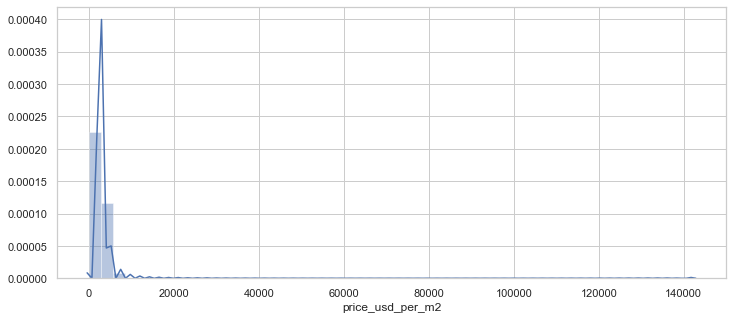

In [39]:
sns.set(style="whitegrid")
x= df.price_usd_per_m2
ax = sns.distplot(x)

**2) Hacé** un `boxplot` de la columna `price_usd_per_m2`

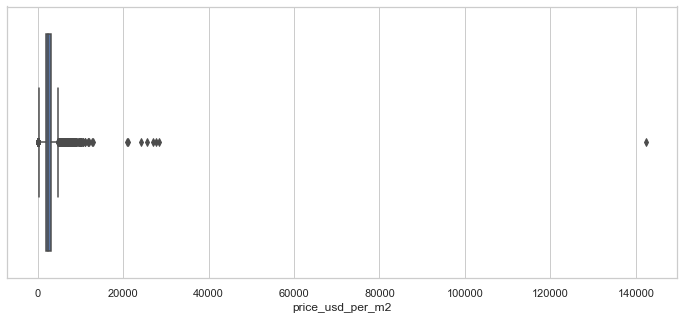

In [40]:
# El boxplot debe estar en esta celda
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["price_usd_per_m2"])

¿A qué conclusión podemos llegar observando estas figuras?
**Responder**

existen valores atipicos(outliers), que afectan en gran manera la distribucion y el boxplot por ende estos valores podrian ser removidos para validar de mejor manera el comportamiento de las distribuciones 

Para confirmar la presencia de outliers vamos a utilizar los percentiles.

**3) Describir** la columna mostrando sus estadísticos

In [41]:
# Describir la columna en esta celda
df.price_usd_per_m2.describe()

count     12973.000000
mean       2695.065767
std        1773.086831
min           0.958333
25%        1959.183673
50%        2510.204082
75%        3125.000000
max      142450.141026
Name: price_usd_per_m2, dtype: float64

Estamos ante la presencia de valores extremos en ambas puntas de la distribución. Vamos a aplicar la técnica del rango intercuartílico para limpiarlos.

Para obtener el rango tenemos que calcular la diferencia entre el tercer y el primer percentil. Luego en base a esto calcularemos los valores mínimos y máximos para definir qué observaciones serán descartadas.

**4) Aplicar la técnica del rango intercuartílico** para limpiar el precio por metro cuadrado. El resultado deberá ser un `dataframe` llamado `df_filtered` sin los outliers.

In [42]:
# Realizar el filtrado intercuartílico en esta celda
p10 = np.percentile(df.price_usd_per_m2, 10)
p90 = np.percentile(df.price_usd_per_m2, 90)
df_filtered = df[(df.price_usd_per_m2 >= p10) & (df.price_usd_per_m2 <= p90)]

**5)** Volver a **plotear** con `distplot` y `boxplot` los precios sin los outliers y observá las diferencias con los anteriores ploteo.

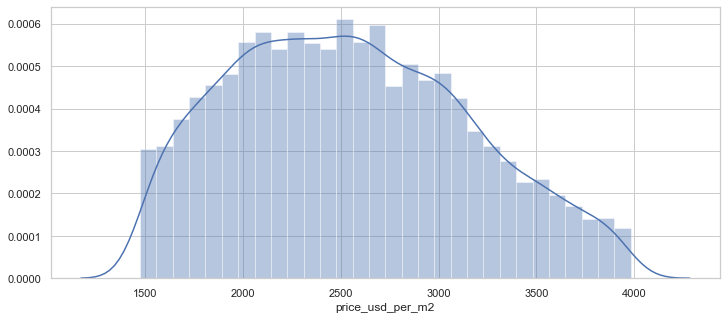

In [43]:
x= df_filtered.price_usd_per_m2
ax = sns.distplot(x)

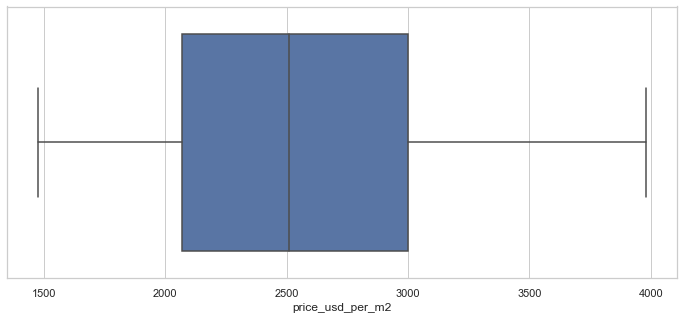

In [44]:
# Hacé el boxplot en esta celda
ax = sns.boxplot(x=df_filtered["price_usd_per_m2"])

**6) Describir** nuevamente la columna mostrando sus estadísticos.

In [45]:
df_filtered.price_usd_per_m2.describe()

count    10379.000000
mean      2553.307722
std        603.933562
min       1475.000000
25%       2071.428571
50%       2509.803922
75%       3000.000000
max       3981.818182
Name: price_usd_per_m2, dtype: float64

Vamos a seguir trabajando con el `dataframe` filtrado

In [46]:
df = df_filtered

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10379 entries, 1 to 13743
Data columns (total 15 columns):
created_on                 10379 non-null datetime64[ns]
property_type              10379 non-null object
place_name                 10379 non-null object
place_with_parent_names    10379 non-null object
lat                        10379 non-null float64
lon                        10379 non-null float64
price_aprox_usd            10379 non-null float64
surface_total_in_m2        10379 non-null float64
surface_covered_in_m2      9988 non-null float64
price_usd_per_m2           10379 non-null float64
floor                      1672 non-null float64
rooms                      8661 non-null float64
expenses                   2895 non-null float64
properati_url              10379 non-null object
barrio                     10379 non-null object
dtypes: datetime64[ns](1), float64(9), object(5)
memory usage: 1.3+ MB


### Valores Faltantes

A diferencia del proyecto pasado, vamos a intentar imputar los valores faltantes para los atributos que consideramos importantes para el mercado inmobiliario. 

Estos atributos son los que informan **superficie (total o cubierta), cantidad de ambientes, precio y precio por metro cuadrado**. 

Veamos en primer lugar cuántos valores faltantes tiene cada atributo. Nos interesa verlo como un porcentaje en relación a la cantidad de observaciones. Si un atributo tiene un elevado porcentaje de faltantes, puede ser mejor no considerarlo en el análisis.

**7) Mostrar** cual es el porcentaje de valores faltantes para cada columna.

In [48]:
# Mostrá los valores faltantes en esta celda
main_columns = ['surface_total_in_m2','surface_covered_in_m2','price_aprox_usd', 'price_usd_per_m2', 'rooms', 'floor', 'expenses']
texto = ''
porce = 0
for item in main_columns:
        valor = sum(pd.isnull(df[item]))
        porce = (valor / df.shape[0])*100
        texto = texto +  item + ': total filas:'+ str(df.shape[0]) + ' nulos: ' + str(valor) + ' porcentaje: ' + str(porce) +  '\n'

print(texto)
#df.surface_covered_in_m2.describe()
#df.surface_covered_in_m2.info()

surface_total_in_m2: total filas:10379 nulos: 0 porcentaje: 0.0
surface_covered_in_m2: total filas:10379 nulos: 391 porcentaje: 3.7672222757491087
price_aprox_usd: total filas:10379 nulos: 0 porcentaje: 0.0
price_usd_per_m2: total filas:10379 nulos: 0 porcentaje: 0.0
rooms: total filas:10379 nulos: 1718 porcentaje: 16.552654398304266
floor: total filas:10379 nulos: 8707 porcentaje: 83.8905482223721
expenses: total filas:10379 nulos: 7484 porcentaje: 72.10713941612872



Podemos ver en los resultados que los atributos `floor` y `expenses` tienen un elevado porcentaje de faltantes.  Una opción sería descartar estas columnas en el análisis. 
Si elimináramos las observaciones (filas) asociadas a estos, perderíamos el 84.79% de los datos, mermando demasiado el conjunto de datos.

Otra opción sería por ejemplo considerar categorías como faltantes o no faltantes o en todo caso analizar si hay algún patrón para poder evitar quitarlos. 

Para avanzar con el proyecto, vamos a quitar esos atributos.

In [49]:
df = df.drop(['floor', 'expenses'], axis = 1)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10379 entries, 1 to 13743
Data columns (total 13 columns):
created_on                 10379 non-null datetime64[ns]
property_type              10379 non-null object
place_name                 10379 non-null object
place_with_parent_names    10379 non-null object
lat                        10379 non-null float64
lon                        10379 non-null float64
price_aprox_usd            10379 non-null float64
surface_total_in_m2        10379 non-null float64
surface_covered_in_m2      9988 non-null float64
price_usd_per_m2           10379 non-null float64
rooms                      8661 non-null float64
properati_url              10379 non-null object
barrio                     10379 non-null object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.1+ MB


Analicemos estrategias para imputar los valores faltantes para los atributos `rooms`, `surface_total_in_m2` y `surface_covered_in_m2`.

Como vimos en las actividades, entre las opciones que tenemos está la posibilidad de imputar por algún medida de tendencia central, como el caso de la media o la mediana. Vamos a avanzar en esa dirección.

**8) Imputar las observaciones faltantes** de la columna `surface_total_in_m2 ` y `surface_covered_in_m2` usando la **media**. 

`Scikit-learn` nos provee la clase `Imputer` que implementa las formas más comunes de imputación.

In [51]:
# Imputar los valores en esta celda

In [52]:
imp = SimpleImputer(strategy='mean')
surface = df.surface_covered_in_m2.values
imp.fit(surface.reshape(-1,1))
print(surface)
surface_imputed = imp.transform(surface.reshape(-1,1))
df.surface_covered_in_m2 = surface_imputed
df.info()

[120.  70. 334. ... 100.  90.  55.]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10379 entries, 1 to 13743
Data columns (total 13 columns):
created_on                 10379 non-null datetime64[ns]
property_type              10379 non-null object
place_name                 10379 non-null object
place_with_parent_names    10379 non-null object
lat                        10379 non-null float64
lon                        10379 non-null float64
price_aprox_usd            10379 non-null float64
surface_total_in_m2        10379 non-null float64
surface_covered_in_m2      10379 non-null float64
price_usd_per_m2           10379 non-null float64
rooms                      8661 non-null float64
properati_url              10379 non-null object
barrio                     10379 non-null object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.1+ MB


Una de las limitaciones que presenta este tipo de imputación es que provoca estimaciones sesgadas de la varianza. Esto impacta en los errores estandar y, por ende, en los tests estadístcos.

Este tipo de técnicas es útil cuando los valores son completamente al azar.

**9) Imputar las observaciones faltantes** de la columna `rooms` usando la **mediana**.

In [53]:
# Imputar con la mediana en esta celda
imp = SimpleImputer(strategy='median')
surface = df.rooms.values
imp.fit(surface.reshape(-1,1))
print(surface)
surface_imputed = imp.transform(surface.reshape(-1,1))
df.rooms = surface_imputed
df.info()

[ 4. nan  6. ...  4.  3.  3.]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10379 entries, 1 to 13743
Data columns (total 13 columns):
created_on                 10379 non-null datetime64[ns]
property_type              10379 non-null object
place_name                 10379 non-null object
place_with_parent_names    10379 non-null object
lat                        10379 non-null float64
lon                        10379 non-null float64
price_aprox_usd            10379 non-null float64
surface_total_in_m2        10379 non-null float64
surface_covered_in_m2      10379 non-null float64
price_usd_per_m2           10379 non-null float64
rooms                      10379 non-null float64
properati_url              10379 non-null object
barrio                     10379 non-null object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 1.1+ MB


### Variables binarias

#### Generar variables binarias para el atributo `property_type`.

Hay que tener en cuenta en este caso que el atributo es categórico.

Para hacerlo usando scikit-learn, por como vienen dados los valores (en formato string), primero conviene convertirlos en numéricos. Para esto usamos `LabelEncoder`.

**10) Convertí** las variables de `property_type` utilizando `LabelEncoder`

In [54]:
# Utilizá LabelEncoder en esta celda
le = LabelEncoder()
categorical_feature_mask = df.dtypes==object
categorical_cols = df.columns[categorical_feature_mask].tolist()

In [55]:
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))
df[categorical_cols].head(10)

,property_type,place_name,place_with_parent_names,properati_url,barrio
1,1,29,32,3,20
3,1,29,32,27,20
4,2,31,34,31,20
5,2,29,32,32,20
7,0,32,35,33,20
8,1,29,32,44,20
11,1,31,34,75,20
13,1,5,11,100,20
15,1,27,30,106,20
16,1,6,12,115,20


In [56]:
#print(df)

df
#le = LabelEncoder()
#integer_encoded = le.fit_transform(array)
#print(integer_encoded)

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio
1,2017-08-29,1,29,32,-34.588912,-58.413494,340000.0,130.0,120.000000,2615.384615,4.0,3,20
3,2017-08-29,1,29,32,-34.595014,-58.427392,180000.0,70.0,70.000000,2571.428571,3.0,27,20
4,2017-08-30,2,31,34,-34.579354,-58.436449,1200000.0,532.0,334.000000,2255.639098,6.0,31,20
5,2017-08-30,2,29,32,-34.579354,-58.436449,1200000.0,532.0,334.000000,2255.639098,6.0,32,20
7,2017-08-30,0,32,35,-34.589776,-58.428558,219000.0,72.0,84.554365,3041.666667,3.0,33,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13737,2018-01-31,1,55,55,-34.598343,-58.499334,180000.0,81.0,77.000000,2222.222222,4.0,10023,36
13739,2018-01-31,1,64,64,-34.598008,-58.487242,135000.0,50.0,84.554365,2700.000000,3.0,10026,36
13741,2018-01-31,1,64,64,-34.606905,-58.490719,340000.0,120.0,100.000000,2833.333333,4.0,10040,36
13742,2018-01-31,0,55,55,-34.608253,-58.500959,210000.0,119.0,90.000000,1764.705882,3.0,10047,36


In [24]:


categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_cols)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])  



In [25]:

#from numpy import array
#data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
#print(data)
#values = array(data)
#print(values)
## integer encode
#label_encoder = LabelEncoder()
#integer_encoded = label_encoder.fit_transform(values)
#print(integer_encoded)

**11) Mostrar** las clases del `LabelEncoder`:

In [26]:
# Mostrar la propiedad classes_ del LabelEncoder que creaste
#list(le.classes_)

In [27]:


#array = df.property_type
#print(array)
#print(df)
#
#integer_encoded = le.fit_transform(array)
#df["property_type"] = le.fit_transform(array)
#print(integer_encoded)
#print(df[categorical_cols])
#print(type(categoricals_df))

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10379 entries, 1 to 13743
Data columns (total 13 columns):
created_on                 10379 non-null datetime64[ns]
property_type              10379 non-null int32
place_name                 10379 non-null int32
place_with_parent_names    10379 non-null int32
lat                        10379 non-null float64
lon                        10379 non-null float64
price_aprox_usd            10379 non-null float64
surface_total_in_m2        10379 non-null float64
surface_covered_in_m2      10379 non-null float64
price_usd_per_m2           10379 non-null float64
rooms                      10379 non-null float64
properati_url              10379 non-null int32
barrio                     10379 non-null int32
dtypes: datetime64[ns](1), float64(7), int32(5)
memory usage: 932.5 KB


In [60]:
# binary encode
ohe = OneHotEncoder(sparse=False)
for item in categorical_cols:
    integer_encoded = df[item]
    print(integer_encoded)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = ohe.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
#inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
#print(inverted)

1        1
3        1
4        2
5        2
7        0
        ..
13737    1
13739    1
13741    1
13742    0
13743    1
Name: property_type, Length: 10379, dtype: int32


AttributeError: 'Series' object has no attribute 'reshape'

Luego con `OneHotEncoder` obtenemos las categorías expresadas como **variables binarias**. 

**12) Aplicar** `OneHotEncoder` sobre las variables categóricas para crear un dataframe `categoricals_df`

In [33]:
# Utilizá OneHotEncoder en esta celda 
#oh = OneHotEncoder(sparse=False)
oh = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False )
for item in categorical_cols:
    df2 = oh.fit_transform(df[item])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


IndexError: tuple index out of range

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder
colT = ColumnTransformer(
    [("dummy_col", OneHotEncoder(categories=[
                                            ['Male', 'Female'],
                                            ['Yes', 'No'],
                                            ['0','1', '2','3+'],
                                            ['Graduate', 'Not Graduate'],
                                            ['No', 'Yes'],
                                            ['Semiurban', 'Urban', 'Rural']
                                            ]
                                ), 
                                [0,1,2,3,4,10]
                                ),
      ("norm", Normalizer(norm='l1'), [5,6,7,8,9])])

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer


preprocess = make_column_transformer((categorical_cols, OneHotEncoder())
)
preprocess.fit_transform(categorical_cols).toarray()  
#[:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:751: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


ValueError: Expected 2D array, got 1D array instead:
array=['property_type' 'place_name' 'place_with_parent_names' 'properati_url'
 'barrio'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
ohe = OneHotEncoder(categorical_features = categorical_feature_mask)
x = ohe.fit_transform(x).toarray()

In [44]:
    
    #df[item].apply(lambda df2: oh.fit_transform(df[item]))
    #integer_encoded = df[]   integer_encoded.reshape(len(integer_encoded), 1)
    #categoricals_df = oh.fit_transform(integer_encoded)
    #df_ohe = oh.fit_transform(df[item])

#df[categorical_cols] = df[categorical_cols].apply(lambda col: oh.fit_transform(col))
#df[categorical_cols].head(10) numero seguimiento 4318712

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


IndexError: tuple index out of range

In [36]:
# categorical_features = boolean mask for categorical columns
# sparse = False output an array not sparse matrix
df

df2

,created_on,property_type,place_name,place_with_parent_names,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,properati_url,barrio
1,2017-08-29,1,29,32,-34.588912,-58.413494,340000.0,130.0,120.000000,2615.384615,4.0,3,20
3,2017-08-29,1,29,32,-34.595014,-58.427392,180000.0,70.0,70.000000,2571.428571,3.0,27,20
4,2017-08-30,2,31,34,-34.579354,-58.436449,1200000.0,532.0,334.000000,2255.639098,6.0,31,20
5,2017-08-30,2,29,32,-34.579354,-58.436449,1200000.0,532.0,334.000000,2255.639098,6.0,32,20
7,2017-08-30,0,32,35,-34.589776,-58.428558,219000.0,72.0,84.554365,3041.666667,3.0,33,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13737,2018-01-31,1,55,55,-34.598343,-58.499334,180000.0,81.0,77.000000,2222.222222,4.0,10023,36
13739,2018-01-31,1,64,64,-34.598008,-58.487242,135000.0,50.0,84.554365,2700.000000,3.0,10026,36
13741,2018-01-31,1,64,64,-34.606905,-58.490719,340000.0,120.0,100.000000,2833.333333,4.0,10040,36
13742,2018-01-31,0,55,55,-34.608253,-58.500959,210000.0,119.0,90.000000,1764.705882,3.0,10047,36


In [ ]:
# apply OneHotEncoder on categorical feature columns
#X_onehot_encoder = onehot_encoder.fit_transform(X) # It returns an numpy array

#print(integer_encoded)
#integer_encoded = df["property_type"]
#print(integer_encoded)
onehot_encoded = list()
print(len(integer_encoded))
print("cantidad de registros")
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded)
categoricals_df = []
categoricals_df = onehot_encoder.fit_transform(integer_encoded)
print (categoricals_df)
print(type(categoricals_df))
print(type(df))

Unimos el nuevo dataframe `categorical_df` con el `dataframe` original `df`. Para esto, necesitamos que tengan el mismo índice.

In [ ]:
#pd.DataFrame(categoricals_df )
cates = categoricals_df[0:,0:1]
print(cates)
print(type(cates))
cats_df = pd.DataFrame(data=categoricals_df)
#print(cats_df)
cats_df = cats_df.set_index(df.index)
df = pd.concat([df, cats_df], axis=1)

print(cats_df)
print(df)


In [ ]:
print(df)
categoricals_df = cats_df.set_index(df.index)
df = pd.concat([df, cats_df], axis=1)
df.head()
print(df)

### Variables calculadas

__Calcular el precio por metro cuadrado (precio/superficie total). Llamar a este atributo `price_m2`.__

Hay que tener cuidado en esta parte respecto de dividir por cero. Para ello, armemos una función de división que contemple eso.

El hecho de crear una columna nueva y no imputar los faltantes es simplemente una decisión. Cuando veamos modelos predictivos, vamos a poder cuantificar el costo de las decisiones que tomemos en términos de performance del modelo.

In [ ]:
def custom_division(x, y):
    if y > 0:
        res = x / y
    else:
        res = 0
    return res

df['price_m2'] = df.apply(lambda x: custom_division(x['price_aprox_usd'], x['surface_total_in_m2']), axis = 1)
df.drop(['price_usd_per_m2'], axis=1, inplace=True)

__Verificar que ya no quedan atributos con valores faltantes__

In [ ]:
# Creamos un dataset con los porcentajes de nulos
df_faltantes = pd.DataFrame(df.isnull().sum() / df.shape[0], columns=['Porcentaje nulos'])
# Solo mostramos los que tengan valores nulos. Si el porcentaje es 0 no se muestra
df_faltantes.loc[~(df_faltantes==0).all(axis=1)]

In [ ]:
print("El dataset final luego del procesamiento tiene {} observaciones".format(df.shape[0]))

De este modo, hemos limpiado valores extremos e imputado valores nulos. El costo de esto fue la pérdida de 685 observaciones, 5% de la cantidad original de filas.